# Custom Object Detection with Web App in Python

## 1. Objective

__STEP 1__:
- Collect data (image) relevant for object detection

- Label the image manually

__STEP 2__:
- Train YOLO V5 Model for Object Detection

- We will use __Google Colab__ to train the model

__STEP 3__:
- Create the data pipeline for getting the predictions from YOLO V5 Model.

## 2. Steps Summary

### Step-1: Data Collection and Labeling

Data preparation is very important task which effect the performance of the model. Always double check while doing:
- Data collection

- Labeling

#### Dos and Don'ts
- It's always recommended to use HD image
  - __Minimum__ width and height of the images should be at least 500 x 500
- Avoid blur images
- Avoid cluttery background images for objects
- The good labeling is when the box covers the object completely and efficiently.

#### Collect Data or Images

We always need to select or collect the data accordingly to our required object. For the general purpose:

- Objective here is to detect __20 objects__
  - Person
  - Car
  - Chair
  - Bottle
  - Sofa
  - Bicycle
  - Horse
  - Boat
  - Motor Bike
  - Cat
  - TV Monitor
  - Cow
  - Sheep
  - Aero Plane
  - Train
  - Dining Table
  - Bus
  - Potted Plant
  - Bird
  - Dog
<br>
<br>
- Always collect more data for good performance in prediction (Deep Learning: more data, better performance)

- Generally, it is good to collect __more than 500+ images__ for single object detection.
  - For example, if you want to train your model for 2 objects, then you have to collect the data for at least 1000 images.

#### Labeling

- Many tools are available to do __labeling__ to images for object detection

- List of tools:
  - Label Studio
  - Diffgram
  - LabelMe
  - LabelImg
  - VGG Image Annotator
  - LabelBox
  - Imglab
  - Semantic Segmentation Editor
  - BeaverDam
<br>
<br>
- i.e. LabelImg:

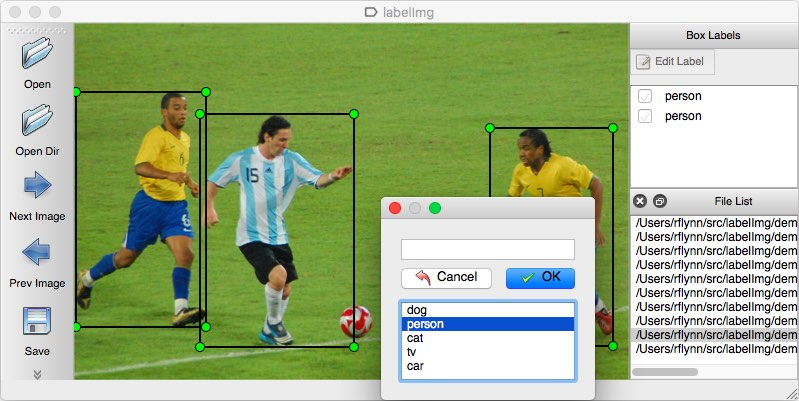

### Step-2: Train YOLOv5 Model

Ref: https://github.com/ultralytics/yolov5

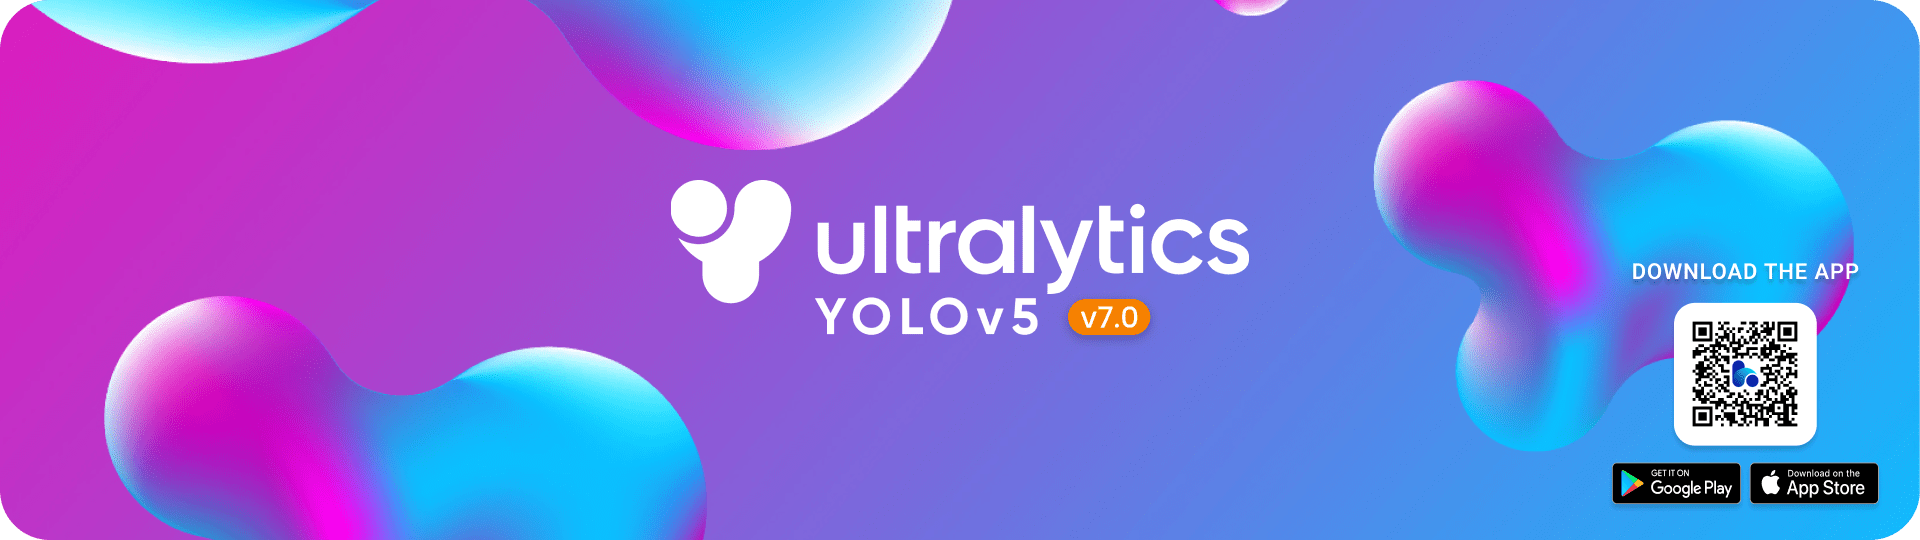

### Step-3: Get Predictions from OpenCV

- Save the YOLO in __onnx__ format.

- Load YOLO model in OpenCV and get bounding boxes.

## 3. Data Preparation
### Collect Data
- In this process, you will do manually collect and label the data, so spend time as much as possible. 
- As a reminder, for a single object detection, at least we collect 500+ images with resolution no less than 500 x 500 px. 
- To collect the hight resolution images, we can use __flickr__, __unsplash__, or [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/)

### Manual Labeling
- Open your terminal and activate `yolo_env` python virtual environment and run `labelImg`
  - `$ source yolo_env/bin/activate`
  - `$ labelImg`
- Click __Open Dir__ and go to images dataset folder.
  - On the bottom right corner, see if all the images have been listed in the __File List__ window.
- Adjust the application setting to `PascalVOC` on the right side bar.
- Create bounding box by clicking `Create RectBox` and give the label accordingly.
- Save the file as `.xml` file and don't rename the file, just keep it as it is.

__Note__:
- This is a completely manual process, and even small error will cost you the precision of the model.
- Make sure you accurately draw the bounding boxes of your object.

### Extract Labels Data from XML files
- In the XML files by labelImg, it stores the information of the image size, the name of the object(s) inside the image, along with bounding box coordinate(s) (x_min, y_min, x_max, y_max).
- For each XML file can contain multiple objects with multiple bounding boxes.
- Our task now is to extract:
  - the size of the image, 
  - the name of the file, 
  - the bounding box information (x_min, y_min, x_max, y_max), 
  - and the name of the object.

In [2]:
import os
from glob import glob
import pandas as pd
from functools import reduce
from xml.etree import ElementTree as et

In [3]:
# Load all xml files and store in a list
xml_files = glob(pathname='1_datapreparation/data_images/*.xml')

In [4]:
# Read XML files
# From each xml file we need to extract filename, size(width, height), object(name, x_min, y_min, x_max, y_max)

def extract_text(filename):
  tree = et.parse(filename)
  root = tree.getroot()
  
  # Extract file name
  img_name = root.find(path='filename').text
  # width and height of the image
  width = root.find(path='size').find(path='width').text
  height = root.find(path='size').find(path='height').text
  
  # object name and its bounding box
  parser = []
  for object in root.findall('object'):
    obj_name = object.find('name').text
    bndbox = object.find('bndbox')
    xmin = bndbox.find('xmin').text
    ymin = bndbox.find('ymin').text
    xmax = bndbox.find('xmax').text
    ymax = bndbox.find('ymax').text
    parser.append([img_name, width, height, obj_name, xmin, xmax, ymin, ymax])

  return parser

In [5]:
parser_all = list(map(extract_text, xml_files))

In [6]:
# Change 3D to 2D list using reduce func
data = reduce(lambda x,y: x+y, parser_all)

In [7]:
# Convert the data into a dataframe
df = pd.DataFrame(data=data, columns=['filename', 'width', 'height', 'object_name', 'xmin', 'xmax', 'ymin', 'ymax'])

In [8]:
df.head()

filename width height  object_name xmin xmax ymin ymax
0  007826.jpg   500    375  diningtable   80  320  217  273
1  007826.jpg   500    375        chair  197  257  193  326
2  007826.jpg   500    375        chair  139  185  184  231
3  007826.jpg   500    375        chair  258  312  180  314
4  007826.jpg   500    375        chair   10   93  195  358

In [9]:
df.shape

(15663, 8)

In [10]:
df['object_name'].value_counts()

object_name
person         5447
car            1650
chair          1427
bottle          634
pottedplant     625
bird            599
dog             538
sofa            425
bicycle         418
horse           406
boat            398
motorbike       390
cat             389
tvmonitor       367
cow             356
sheep           353
aeroplane       331
train           328
diningtable     310
bus             272
Name: count, dtype: int64

### Labels for YOLO Model

For YOLO model, we need to __convert__ the __[object_name, xmin, xmax, ymin, ymax]__ --> __[object_name, obj_center_x, obj_center_y, object_w, object_h]__ where:
- __(obj_center_x, obj_center_y)__: center position of object normalized to width of the image.
- __object_w__: width of bounding box normalized to the width of the image.
- __object_h__: height of bounding box normalized to the height of the image.

The formula for the conversion is as follows:
- __obj_center_x__: ((xmin + xmax)/2)/(width of the image)
- __obj_center_y__: ((ymin + ymax)/2)/(height of the image)
- __object_w__: (xmax - xmin)/(width of the image)
- __object_h__: (ymax - ymin)/(height of the image)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     15663 non-null  object
 1   width        15663 non-null  object
 2   height       15663 non-null  object
 3   object_name  15663 non-null  object
 4   xmin         15663 non-null  object
 5   xmax         15663 non-null  object
 6   ymin         15663 non-null  object
 7   ymax         15663 non-null  object
dtypes: object(8)
memory usage: 979.1+ KB


Notice that the data type of the value for numerical columns is still object. Let's change that!

In [20]:
cols = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df[cols] = df[cols].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     15663 non-null  object
 1   width        15663 non-null  int64 
 2   height       15663 non-null  int64 
 3   object_name  15663 non-null  object
 4   xmin         15663 non-null  int64 
 5   xmax         15663 non-null  int64 
 6   ymin         15663 non-null  int64 
 7   ymax         15663 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 979.1+ KB


In [22]:
# Coordinate Conversion
object_center_x = []
object_center_y = []
object_width = []
object_height = []
for row, data in df.iterrows():
  object_center_x.append(((data['xmin'] + data['xmax'])/2)/data['width'])
  object_center_y.append(((data['ymin'] + data['ymax'])/2)/data['height'])
  object_width.append((data['xmax'] - data['xmin'])/data['width'])
  object_height.append((data['ymax'] - data['ymin'])/data['height'])

df['object_center_x'] = object_center_x
df['object_center_y'] = object_center_y
df['object_width'] = object_width
df['object_height'] = object_height

In [25]:
df[df['filename'] == '000001.jpg']

filename  width  height object_name  xmin  xmax  ymin  ymax   
14171  000001.jpg   1024     657         car    14   301   335   522  \
14172  000001.jpg   1024     657         car   269   571   345   489   
14173  000001.jpg   1024     657         car   502   798   342   450   
14174  000001.jpg   1024     657         car   709  1009   333   438   

       object_center_x  object_center_y  object_width  object_height  
14171         0.153809         0.652207      0.280273       0.284627  
14172         0.410156         0.634703      0.294922       0.219178  
14173         0.634766         0.602740      0.289062       0.164384  
14174         0.838867         0.586758      0.292969       0.159817

### Train-Test Split: Folder Structure for YOLO Model

After we calculate using the conversion formula, we need to structure our project folder as follows:

- __data_images__:
  - __train__:
    - 001.jpg
    - 001.txt --> [object_name, center_x, center_y, w, h]
    - ...
  - __test__ :
    - 101.jpg
    - 101.txt --> [object_name, center_x, center_y, w, h]
    - ...

In [30]:
# How many data images in our project?
images = df.filename.unique()
print(len(images))

5012


In [60]:
# We will split 5012 images into train and test. Say, 80% train, and 20% Test
img_df = pd.DataFrame(images, columns=['filename'])
img_df.sort_values(by='filename', inplace=True)
img_df.reset_index(drop=True, inplace=True)

img_train = tuple(img_df.sample(frac=0.8)['filename']) # shuffle and pick 80% of images
img_test = tuple([img for img in img_df['filename'] if img not in img_train]) # take the rest of 20% images
print(len(img_train), len(img_test))

4010 1002


In [65]:
# Now, we will split the data frame based on the train and test image set
train_df = df[df['filename'].isin(img_train)]
test_df = df[df['filename'].isin(img_test)]

In [66]:
# Label encoding
def label_encoding(x):
  labels = {
    'person': 0, 
    'car': 1, 
    'chair': 2, 
    'bottle': 3, 
    'pottedplant': 4, 
    'bird': 5, 
    'dog': 6, 
    'sofa': 7, 
    'bicycle': 8, 
    'horse': 9, 
    'boat': 10, 
    'motorbike': 11, 
    'cat': 12, 
    'tvmonitor': 13, 
    'cow': 14, 
    'sheep': 15, 
    'aeroplane': 16, 
    'train': 17, 
    'diningtable': 18, 
    'bus': 19
  }
  return labels.get(x)

### Label Encoding to Objects
Now, we need to convert the `object_names` into specific IDs. The reason for that is in any ML/DL model, we cannot train a text. Hence we need to convert this into somekind of numerical information. Such process is called __Label Endoding__.

In [70]:
train_df['object_id'] = train_df['object_name'].apply(lambda x: label_encoding(x))
test_df['object_id'] = test_df['object_name'].apply(lambda x: label_encoding(x))

/var/folders/vm/3txrml4d02zch5_v8m3tqwnr0000gp/T/ipykernel_24782/3671087811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['object_id'] = train_df['object_name'].apply(lambda x: label_encoding(x))
/var/folders/vm/3txrml4d02zch5_v8m3tqwnr0000gp/T/ipykernel_24782/3671087811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['object_id'] = test_df['object_name'].apply(lambda x: label_encoding(x))


### Save Image and Labels in Text

In [86]:
import os
from shutil import move

In [89]:
# Create Training and Testing Folder

train_folder = '1_datapreparation/data_images/train'
test_folder = '1_datapreparation/data_images/test'

os.mkdir(train_folder)
os.mkdir(test_folder)

In [96]:
"""
What we do now is to create a groupby object by filename, and then set the filename as the index, 
then save it to txt file.
"""
cols = ['filename', 'object_id', 'object_center_x', 'object_center_y', 'object_width', 'object_height']
groupby_obj_train = train_df[cols].groupby(by='filename')
groupby_obj_test = test_df[cols].groupby(by='filename')

In [95]:
# Save each image in train/test folder and respective labels in .txt
def save_data(filename, folder_path, group_obj):
  # move image
  src = os.path.join('1_datapreparation/data_images/', filename)
  dst = os.path.join(folder_path, filename)
  move(src, dst) # move image to the destination folder 
  
  # split the extension from a path name
  text_filename = os.path.join(folder_path, 
                               os.path.splitext(filename)[0]+'.txt')
  # save the labels
  group_obj.get_group(filename).set_index('filename').to_csv(text_filename, sep = ' ', index = False, header = False)

In [108]:
# Move train image in train folder
for img_name in img_train:
  save_data(img_name, train_folder, groupby_obj_train)

In [109]:
# Move test image in test folder
for img_name in img_test:
  save_data(img_name, test_folder, groupby_obj_test)

## Train the YOLO Model

### Create a YAML file
In order to train the YOLO model, we need to create a YAML file beforehand. In that file, we need to specify the train and validation set location, the number of clasess, and the name of the objects.

```
train: data_images/train
val: data_images/test
nc: 20
names: [
  'person', 
  'car', 
  'chair', 
  'bottle', 
  'pottedplant', 
  'bird', 
  'dog', 
  'sofa', 
  'bicycle', 
  'horse', 
  'boat', 
  'motorbike', 
  'cat', 
  'tvmonitor', 
  'cow', 
  'sheep', 
  'aeroplane', 
  'train', 
  'diningtable', 
  'bus'
]
```
- Save it to __data_images/data.yaml__

### Setting Up Google Colab
- The challenge of training YOLO model is it requires a fast GPU. 
- However, not everybody has a fast GPU inside their computer/laptop.
- That's why we will use Google Colab that offers a free GPU. We will use it effectively.
- The created Google Colab for this project can be accessed here: https://colab.research.google.com/drive/1J0G6qCgq4Y-vQBSg6TeYKoA20UtbSmfo?usp=sharing

__Notes:__
- Training our model will take hardly like 2 - 3 hours. Hence, we only require the GPU only for a total to 3 hours.
- To access GPU, go to `Runtime` --> `Change Runtime Type` --> `GPU`
- Google will still calculate the use of GPU even in the idle time. Hence, __Terminate__ the session for the notebook that is not currently used by going to `Runtime` --> `Manage Sessions` --> `Terminate`

### Results and Evaluation
After the training process, we can take a look at the performance of the model predict the validation dataset.
- Compare the image of val_batchN_labels.jpg vs val_batchN_pred.jpg to see how accurate our model predicts the object.
- Inspect the confusion matrix to see what labels that have the highest and lowest prediction accuracy.
- Inspect the results.png to see the loss, precision, and recall metrics over epochs.
  - The result shows that there is stil scope of in increasing our model precision by training it with more epochs.
  - If you want to get more precision, you can run for more epochs, let's say 100 epochs.

## Prediction from YOLO Model

### Import the Library

In [2]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader
from matplotlib import pyplot as plt
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

### Load the Data.yaml file

In [3]:
# Load the YAML file 
with open('1_datapreparation/data_images/data.yaml', 'r') as file:
  data_yaml = yaml.load(file, Loader=SafeLoader)

labels = data_yaml['names']
print(labels)


['person', 'car', 'chair', 'bottle', 'pottedplant', 'bird', 'dog', 'sofa', 'bicycle', 'horse', 'boat', 'motorbike', 'cat', 'tvmonitor', 'cow', 'sheep', 'aeroplane', 'train', 'diningtable', 'bus']


### Load the YOLO Model with OpenCV

In [4]:
# Load the YOLO Model
yolo = cv2.dnn.readNetFromONNX('2_predictions/Model/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # If you have GPU environment with you, you can select DNN_TARGET_CUDA

### Get Detection from YOLO Model

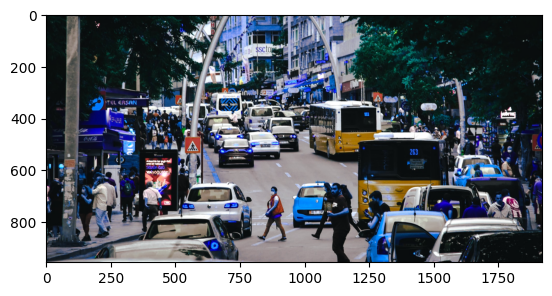

'The following code will make the Kernel Crash due to Jupyter Notebook Environment'

In [5]:
# Load the input image
img = cv2.imread('2_predictions/street_image.jpeg')
image = img.copy()
plt.imshow(image)
plt.show()

"""The following code will make the Kernel Crash due to Jupyter Notebook Environment"""
# cv2.imshow("Frame", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In order to make a prediction using YOLO, we need to make a squared frame corresponding to the maximum pixel of either width and height. So, if we have 10 x 15 pixels image, we need to make a 15 x 15 frame pixels image. Let's do that!

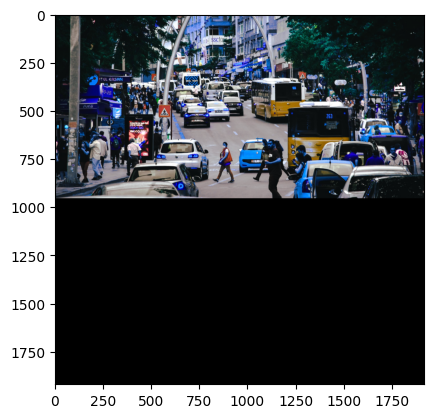

In [6]:
# Get the image properties
row, col, d = image.shape

# Create a squared empty frame
max_rc = max(row, col)
input_image = np.zeros(shape=(max_rc, max_rc, 3), dtype=np.uint8)

# Overlay the empty frame with our input image
input_image[:row, :col] = image
plt.imshow(input_image)
plt.show()


In [7]:
# Get the prediction
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(
  image=input_image, 
  scalefactor = 1/255, 
  size = (INPUT_WH_YOLO, INPUT_WH_YOLO), # Remember that we train our YOLO model with 640 pixels image
  swapRB = True, # Swap BGR format from OpenCV to RGB format
  crop = False)

yolo.setInput(blob)

preds = yolo.forward() # detection or prediction from YOLO

In [8]:
print(preds)
print(preds.shape)

[[[5.80621433e+00 5.61638832e+00 1.55017996e+01 ... 1.30999675e-02
   3.14337225e-03 7.30512571e-03]
  [1.33672886e+01 5.60020447e+00 2.74991398e+01 ... 1.32319266e-02
   2.42933165e-03 5.86233893e-03]
  [1.75551720e+01 5.80859852e+00 3.15765266e+01 ... 1.50183309e-02
   2.07614875e-03 6.88346755e-03]
  ...
  [5.58351929e+02 6.01207214e+02 1.65178558e+02 ... 7.17935115e-02
   2.57371869e-02 9.42746624e-02]
  [5.80930176e+02 6.01475525e+02 1.15896179e+02 ... 7.28558898e-02
   3.34217101e-02 1.21444955e-01]
  [6.13743896e+02 6.06630920e+02 1.19908333e+02 ... 9.02139693e-02
   4.65875082e-02 1.49108186e-01]]]
(1, 25200, 25)


### Understand the YOLO Model Output Prediction
- Prediction output from YOLO contains the following information __(1, N_bounding_box, N_cols)__
- __N_bounding_box__: the number of bounding box generated by YOLO from the input image
- __N_cols__: the number of columns;
  - where 5 cols containing:
    - obj_center_x
    - obj_center_y
    - obj_width
    - obj_height
    - confidence
  - and the remaining cols are __Probability Score__ for each class.

For ex: Here we have __(1, 25200, 25)__, it means:
- it has __25.200__ bounding boxes
- it has __25__ columns, where:
  - the first __5__ columns are the properties of the bounding box + confidence value
  - the remaining __20__ columns are the probability score of 20 classes.

#### Non Maximum Suppression

From here, you might notice that only from a single image, the model deducts 25200 bounding boxes. That's too many boxes in a single image for our eyes can see!

Actually, YOLO outputs so many duplicate deductions, that's why we will do the __non maximum suppression__ to:
- __remove all the duplicate bounding boxes__,
- and __select only specific bounding boxs which are having some good confidence and probability score__.

__Note__: 
- to filter the bounding boxes based on the confidence and probability scores more accurately, you can increase the threshold here. 

In [9]:
# Initialize some variables to prepare for the filtering process
detections = preds[0]
boxes = []
confidences = []
classes = []

# Width and height of the input image --> (1920, 1920)
image_w, image_h = input_image.shape[:2]
x_factor = image_w / INPUT_WH_YOLO # 1920 / 640
y_factor = image_h / INPUT_WH_YOLO # 1920 / 640

# Filter detection based on confidence score (0.4) and probability score (0.25)
for i in range(len(detections)):
  row = detections[i]
  confidence = row[4]
  if confidence > 0.4:
    class_score = row[5:].max() # Take the maximum probability from the 20 objects
    class_id = row[5:].argmax() # Get the index position at which mas probability occur
    if class_score > 0.25:
      cx, cy, w, h = row[:4]
      # construct the bounding box from four values: left, top, width, and height
      left = int((cx - 0.5 * w) * x_factor)
      top = int((cy - 0.5 * h) * y_factor)
      width = int(w * x_factor)
      height = int(h * y_factor)
      
      box = np.array([left, top, width, height])
      
      # append values into the list
      confidences.append(confidence)
      boxes.append(box)
      classes.append(class_id)
  
# Clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

# Non Maximum Suppression
# Return the index position we need to consider 
index = cv2.dnn.NMSBoxes(bboxes = boxes_np, scores = confidences_np, score_threshold = 0.2, nms_threshold = 0.45).flatten()
print(index)
    

[356 316 296 194 133 124 298 238 330 245 214 227  12  86 123 218 349 138
 229 334   3 293 320  34 161  24]


The index says that out of 25.200 rows, we only need to consider __26__. From this we found the 26 objects having the good confidence score and good probability score.

#### Draw Bounding Box

In [10]:
# Draw the Bounding Box
for idx in index:
  # Extract the bounding box
  x, y, w, h = boxes_np[idx]
  bb_conf = int(confidences[idx]*100)
  class_id = classes[idx]
  class_name = labels[class_id]

  text = '{}: {}%'.format(class_name, bb_conf)

  # Draw the bounding box
  cv2.rectangle(img=image, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=2)

  # Draw a text box to put text
  cv2.rectangle(img=image, pt1=(x, y - 30), pt2=(x + w, y), color=(255, 255, 255), thickness=-1) # thickness -1 to fill all the rectangle

  # Put Text inside the text box
  cv2.putText(img=image, text=text, org=(x, y - 10), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.7, color=(0, 0, 0), thickness=1)

Text(0.5, 1.0, 'Yolo Prediction')

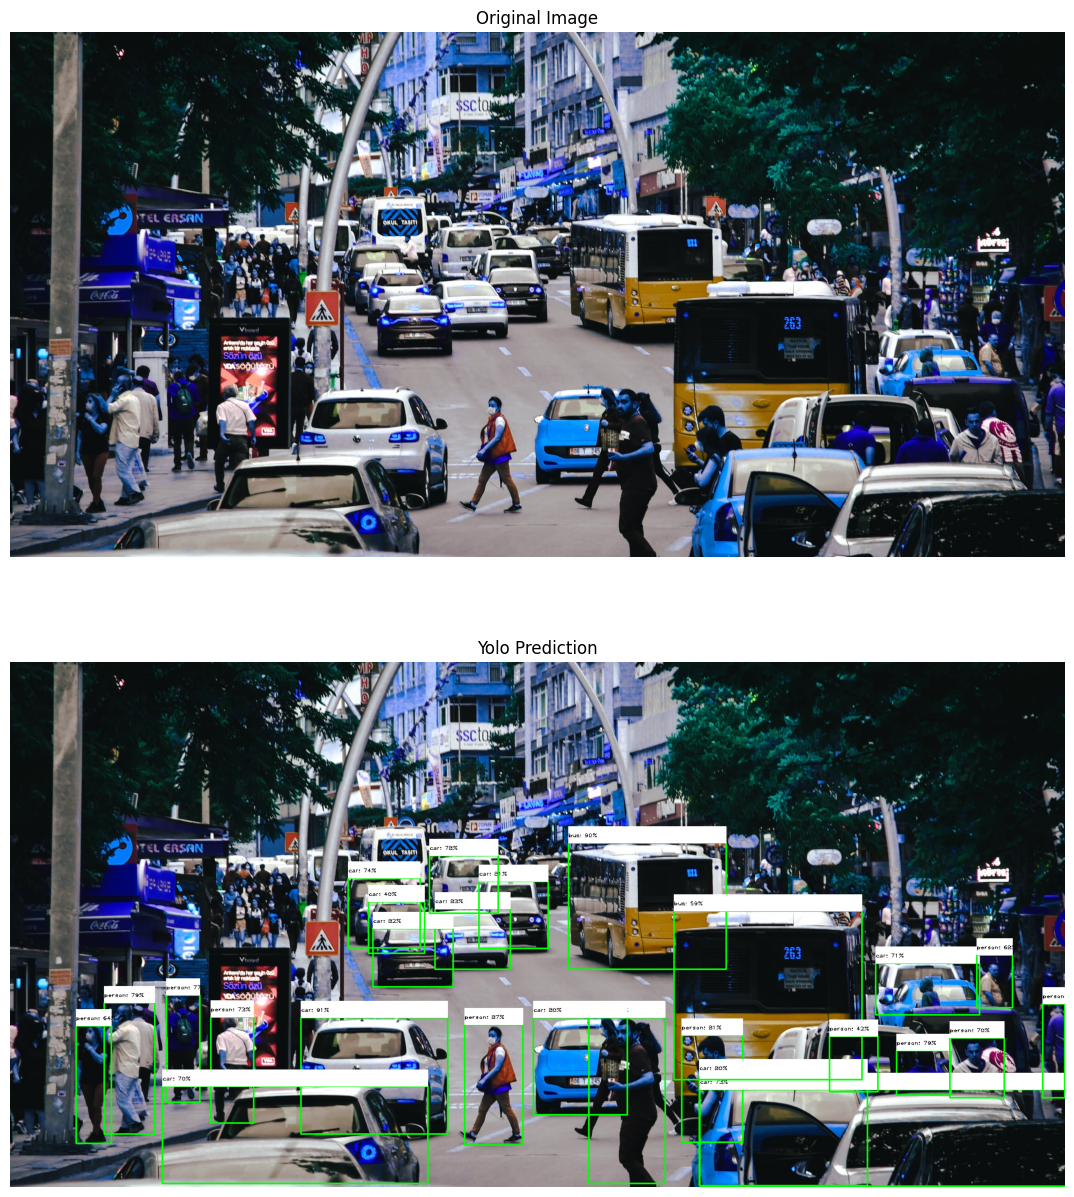

In [16]:
# create figure
fig = plt.figure(figsize=(20, 15))

# setting values to rows and column variables
fig_rows = 2
fig_columns = 1

# Adds a subplot at the 1st position
fig.add_subplot(fig_rows, fig_columns, 1)

# showing image
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

# Adds a subplot at the 1st position
fig.add_subplot(fig_rows, fig_columns, 2)

# showing image
plt.imshow(image)
plt.axis('off')
plt.title("Yolo Prediction")

### Create YOLO Prediction Module

Now, we will create a stand-alone file to make a prediction using custom-trained YOLO model. Save the following code to a file namely `yolo_predictions.py` inside `2_predictions` directory.

In [ ]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

class YOLO_pred:
  def __init__(self, path_2_onnx_model, path_2_data_yaml):
    
    # Load the YAML file
    with open(path_2_data_yaml, 'r') as file:
      data_yaml = yaml.load(file, Loader=SafeLoader)

    self.labels = data_yaml['names']
    self.nc = data_yaml['nc']

    # Load the YOLO Model
    self.yolo = cv2.dnn.readNetFromONNX(path_2_onnx_model)
    self.yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    self.yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # If you have GPU environment with you, you can select DNN_TARGET_CUDA

  def prediction(self, image):
    
    # Get the image properties
    row, col, d = image.shape

    # Create a squared empty frame
    max_rc = max(row, col)
    input_image = np.zeros(shape=(max_rc, max_rc, 3), dtype=np.uint8)

    # Create a squared empty frame
    max_rc = max(row, col)
    input_image = np.zeros(shape=(max_rc, max_rc, 3), dtype=np.uint8)

    # Overlay the empty frame with our input image
    input_image[:row, :col] = image

    # Get the prediction
    INPUT_WH_YOLO = 640
    blob = cv2.dnn.blobFromImage(
      image=input_image, 
      scalefactor = 1/255, 
      size = (INPUT_WH_YOLO, INPUT_WH_YOLO), # Remember that we train our YOLO model with 640 pixels image
      swapRB = True, # Swap BGR format from OpenCV to RGB format
      crop = False
      )

    self.yolo.setInput(blob)

    preds = self.yolo.forward() # detection or prediction from YOLO

    # Initialize some variables to prepare for the filtering process
    detections = preds[0]
    boxes = []
    confidences = []
    classes = []

    # Width and height of the input image --> (1920, 1920)
    image_w, image_h = input_image.shape[:2]
    x_factor = image_w / INPUT_WH_YOLO # 1920 / 640
    y_factor = image_h / INPUT_WH_YOLO # 1920 / 640

    # Filter detection based on confidence score (0.4) and probability score (0.25)
    for i in range(len(detections)):
      row = detections[i]
      confidence = row[4]
      if confidence > 0.4:
        class_score = row[5:].max() # Take the maximum probability from the 20 objects
        class_id = row[5:].argmax() # Get the index position at which mas probability occur
        if class_score > 0.25:
          cx, cy, w, h = row[:4]
          # construct the bounding box from four values: left, top, width, and height
          left = int((cx - 0.5 * w) * x_factor)
          top = int((cy - 0.5 * h) * y_factor)
          width = int(w * x_factor)
          height = int(h * y_factor)
          
          box = np.array([left, top, width, height])
          
          # append values into the list
          confidences.append(confidence)
          boxes.append(box)
          classes.append(class_id)
  
    # Clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # Non Maximum Suppression
    # Return the index position we need to consider 
    index = cv2.dnn.NMSBoxes(bboxes = boxes_np, scores = confidences_np, score_threshold = 0.2, nms_threshold = 0.45).flatten()

    # Draw the Bounding Box
    for idx in index:
      # Extract the bounding box
      x, y, w, h = boxes_np[idx]
      bb_conf = int(confidences[idx]*100)
      class_id = classes[idx]
      class_name = self.labels[class_id]
      bb_color = self.generate_colors(class_id)
      
      text = '{}: {}%'.format(class_name, bb_conf)

      # Draw the bounding box
      cv2.rectangle(img=image, pt1=(x, y), pt2=(x + w, y + h), color=bb_color, thickness=2)

      # Draw a text box to put text
      cv2.rectangle(img=image, pt1=(x, y - 30), pt2=(x + w, y), color=bb_color, thickness=-1) # thickness -1 to fill all the rectangle

      # Put Text inside the text box
      cv2.putText(img=image, text=text, org=(x, y - 10), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=0.7, color=(0, 0, 0), thickness=1)
    
    return image
  
  def generate_colors(self, ID):
    np.random.seed(10)
    colors = np.random.randint(100, 255, size=(self.nc, 3)).tolist()
    return tuple(colors[ID])

## Final Object Detection from Image
Save the following to `main_object_detection_image.py`

In [17]:
import cv2
from yolo_predictions import YOLO_pred

yolo = YOLO_pred(onnx_model='2_predictions/Model/weights/best.onnx', data_yaml='1_datapreparation/data_images/data.yaml')
result = yolo.prediction(path_2_input_image='2_predictions/street_image.jpeg')
cv2.imshow('Yolo Predicton', result)
cv2.waitKey(0)
cv2.destroyAllWindows()
